In [2]:
cd ..

d:\research\fedmiss_bench


In [24]:
import os
import itertools
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

nnn_imp_fed = {
    'simple': ['local', 'fedavg'],
    'em': ['local', 'fedavg'],
    'linear_ice': ['local', 'fedavg'],
    'missforest': ['local', 'fedtree']
}

nn_imp_fed = {
    'miwae': ['local', 'fedavg', 'fedavg_ft', 'fedprox'],
    'gain': ['local', 'fedavg', 'fedavg_ft', 'fedprox'],
}

dataset_dp = {
    'vehicle_np': ['natural-partition'],
    'school_np': ['natural-partition'],
}

dataset_metric_pred = {
    'vehicle_np': ['accuracy', 'f1', 'auc', 'prc'],
    'school_np': ['mse', 'mae', 'r2', 'msle'],
}

In [25]:
def load_ret(datasets, imputers, met):
    
    rets = []
    unfinished = {}
    for dataset in datasets:
        
        data_partition = dataset_dp[dataset]
        unfinished[dataset] = {}
        missing = ['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter']
        models = ['nn']
        
        for imputer in imputers:
            unfinished[dataset][imputer] = set()
            print(dataset, imputer)            
            if imputer in nnn_imp_fed:
                rounds = [0,1,2,3,4,5,6,7,8,9]
                feds = nnn_imp_fed[imputer]
            else:
                rounds = [0,1,2,3,4]
                feds = nn_imp_fed[imputer]

            param = itertools.product(feds, data_partition, missing, rounds, models)
            dir_path = f'./results/raw_results/eval_results/alpha/{dataset}/'

            count, total = 0, 0
            for i, (fed, dp, ms, round, model) in enumerate(param):
                
                file_path = f'{dir_path}{dp}_{ms}/{imputer}/{fed}/{round}/{model}/eval_results.json'
                total += 1
                try:
                    with open(file_path, 'r') as f:
                        ret = json.load(f)
                        if met == 'imp':
                            metrics = ['rmse', 'sliced-ws']
                            ret_metrics = [ret['results']['imp_quality'][metric] for metric in metrics]
                        elif met == 'pred':
                            metrics = dataset_metric_pred[dataset]
                            ret_metrics = [ret['results']['pred_performance'][metric] for metric in metrics]
                        else:
                            raise ValueError('Invalid metric')
                        
                        for id, items in enumerate(zip(*ret_metrics)):
                            setting = {
                                'dataset': dataset,
                                'data_partition': dp,
                                'imputer': imputer,
                                'fed': fed,
                                'missing': ms,
                                'round': round,
                                'model': model,
                                'client_id': id
                            }
                            setting.update({metric: item for metric, item in zip(metrics, items)})
                            rets.append(setting)
                
                except Exception as e:
                    print(e)
                    count += 1
                    unfinished[dataset][imputer].add((dataset, dp, ms, imputer, fed, round, model, e))
                    continue

            print(f'{count}/{total}')
        
    return rets, unfinished

In [26]:
result_pred, unfinished = load_ret(
    ['vehicle_np', 'school_np'],
    ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], 
    met = 'pred'
)

vehicle_np simple
0/100
vehicle_np em
0/100
vehicle_np linear_ice
0/100
vehicle_np missforest
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/0/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/1/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/2/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/3/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/4/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/5/nn/e

In [28]:
result_imp, unfinished = load_ret(
    ['vehicle_np', 'school_np'],
    ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain'], 
    met = 'imp'
)

vehicle_np simple
0/100
vehicle_np em
0/100
vehicle_np linear_ice
0/100
vehicle_np missforest
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/0/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/1/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/2/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/3/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/4/nn/eval_results.json'
[Errno 2] No such file or directory: './results/raw_results/eval_results/alpha/vehicle_np/natural-partition_mcar/missforest/local/5/nn/e

In [35]:
df_pred = pd.DataFrame(result_pred)
df_pred = df_pred[df_pred['model'] == 'nn']
df_pred = df_pred.drop(columns=['model'])
df_pred = df_pred[df_pred['client_id'] != 10].reset_index(drop=True)
df_pred = df_pred.replace({'fedtree': 'fedavg'})

dataset_metric = {
    'vehicle_np': 'accuracy',
    'school_np': 'mae',
}

dataset_task = {
    'vehicle_np': 'clf',
    'school_np': 'reg',
}

df_pred['pred'] = df_pred.apply(lambda x: x[dataset_metric[x['dataset']]], axis=1)
df_pred = df_pred.drop(['accuracy', 'f1', 'auc', 'prc', 'mse', 'mae', 'r2', 'msle'], axis=1)
df_pred['task_type'] = df_pred['dataset'].map(dataset_task)
df_pred.columns = ['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id', 'client_id', 'pred', 'task_type']
df_pred.head()

,dataset,partition,imp,fed,missing,round_id,client_id,pred,task_type
0,vehicle_np,natural-partition,simple,local,mcar,0,0,0.969828,clf
1,vehicle_np,natural-partition,simple,local,mcar,0,1,0.919118,clf
2,vehicle_np,natural-partition,simple,local,mcar,0,2,0.934307,clf
3,vehicle_np,natural-partition,simple,local,mcar,0,3,0.976744,clf
4,vehicle_np,natural-partition,simple,local,mcar,0,4,0.943548,clf


In [39]:
df_imp = pd.DataFrame(result_imp)
df_imp = df_imp[df_imp['client_id'] != 10].reset_index(drop=True)
df_imp = df_imp.drop(columns=['model'])
df_imp = df_imp.replace({'fedtree': 'fedavg'})
df_imp.columns = ['dataset', 'partition', 'imp', 'fed', 'missing', 'round_id', 'client_id', 'rmse', 'sliced-ws']
df_imp.head()

,dataset,partition,imp,fed,missing,round_id,client_id,rmse,sliced-ws
0,vehicle_np,natural-partition,simple,local,mcar,0,0,0.198717,0.059457
1,vehicle_np,natural-partition,simple,local,mcar,0,1,0.193908,0.057849
2,vehicle_np,natural-partition,simple,local,mcar,0,2,0.195987,0.051599
3,vehicle_np,natural-partition,simple,local,mcar,0,3,0.187817,0.054968
4,vehicle_np,natural-partition,simple,local,mcar,0,4,0.190421,0.058600


In [40]:
def agg_client(df, method = 'mean', metric = 'pred'):
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id'], observed = False).agg(
        {metric: method}).reset_index()
    return df_agg

def agg_client_round(df, method = 'mean', metric = 'pred'):
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {metric: method}).reset_index()
    return df_agg

def calculate_improvement(df, metric = 'pred'):
    
    local_baseline = df[df['fed'] == 'local'].copy()
    local_baseline.rename(columns={metric: f'{metric}_local'}, inplace=True)
    keys = ['dataset', 'partition', 'missing', 'imp', 'client_id', 'round_id']
    df = df.merge(local_baseline[keys + [f'{metric}_local']], on=keys, how='left')
    del local_baseline
    
    if metric == 'pred':
    
        df['pred_diff'] = df.apply(
            lambda x: (x['pred'] - x['pred_local']) if x['task_type'] == 'clf' else -(x['pred'] - x['pred_local']), axis=1
        )
        
        # df['pred_improv'] = df.apply(
        #     lambda x: (x['pred_diff'] / (x['pred_local'] + 1e-5)) * 100 if x['task_type'] == 'reg' else x['pred_diff']*100, axis=1
        # )
        df['pred_improv'] = df.apply(
             lambda x: (x['pred_diff'] / (x['pred_local'] + 1e-5)) * 100, axis=1
        )
    else:
        df[f'{metric}_diff'] = df.apply(
            lambda x: -(x[metric] - x[f'{metric}_local']), axis=1
        )
        df[f'{metric}_improv'] = df.apply(
            lambda x: (x[f'{metric}_diff'] / (x[f'{metric}_local'] + 1e-5)) * 100, axis=1
        )
    
    df = df[df['fed'] != 'local']
    #final_df = df[['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id', 'round_id', 'rmse_diff', 'rmse_improv', 'ws_diff', 'ws_improv']]
    
    return df

def agg_client_improv(df, method = 'mean', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'client_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

def agg_client_improv2(df, method = 'mean', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

def agg_client_improv_std(df, method = 'std', metric = 'improv', m = 'pred'):
    print(df.columns)
    df['fed'] = df['fed'].astype(str)
    df_agg = df.groupby(['dataset', 'partition', 'missing', 'imp', 'fed', 'round_id'], observed = False).agg(
        {f'{m}_{metric}': method}).reset_index()
    return df_agg

df_pred_improv = calculate_improvement(df_pred)
df_imp_improv = calculate_improvement(df_imp, metric = 'rmse')
df_imp_improv_ws = calculate_improvement(df_imp, metric = 'sliced-ws')

In [41]:
# plotting mapping
dataset_dp = {
    'vehicle_np': ['natural-partition'],
    'school_np': ['natural-partition'],
}

scenario_mapping = {
    'mcar': 'MCAR',
    'mar-homog': 'MAR(HG)',
    'mnar2-homog': 'MNAR(HG)',
    'mnar2-heter': 'MNAR(HT)',
    'mar-heter': 'MAR(HT)',
}

dp_mapping = {
    'natural-partition': 'NP',
}

dataset_mapping = {
    'vehicle_np': 'VHCL',
    'school_np': 'SCHL',
}

method_mapping = {
    'simple': 'Simple',
    'em': 'EM',
    'linear_ice': 'Linear-ICE',
    'missforest': 'MissForest',
    'miwae': 'MIWAE',
    'gain': 'GAIN',
}

dataset_metric_mapping = {
    'vehicle_np': 'ACCU',
    'school_np': 'MAE',
}

vehicle_np
(880, 12)
mcar simple -2.46723834767824 3.3464476545723407
mcar em -0.7771504050094581 1.7042880242840879
mcar linear_ice -1.8693188253242672 7.901034400595473
mcar missforest nan nan
mcar miwae -4.519719128045984 7.800196211106813
mcar gain -4.718323445308239 3.2727012615253956
(880, 12)
mar-homog simple -0.950386774486587 3.4628804988730213
mar-homog em -1.4801073087943106 5.02333681899882
mar-homog linear_ice -3.0011860130984744 8.050065717640676
mar-homog missforest nan nan
mar-homog miwae -5.663919348406451 7.01511350484181
mar-homog gain 4.530481632875021 8.890162869452224
(880, 12)
mnar2-homog simple -0.8713303190160585 2.995950311125423
mnar2-homog em -1.5555152916216368 2.4678575398532177
mnar2-homog linear_ice -0.8296269650142832 4.457754510463203
mnar2-homog missforest nan nan
mnar2-homog miwae -4.489180753535801 4.64778630894655
mnar2-homog gain 5.061923016049421 10.42463245637864
(880, 12)
mar-heter simple 5.636957152642481 3.087989244457365
mar-heter em 4.63253

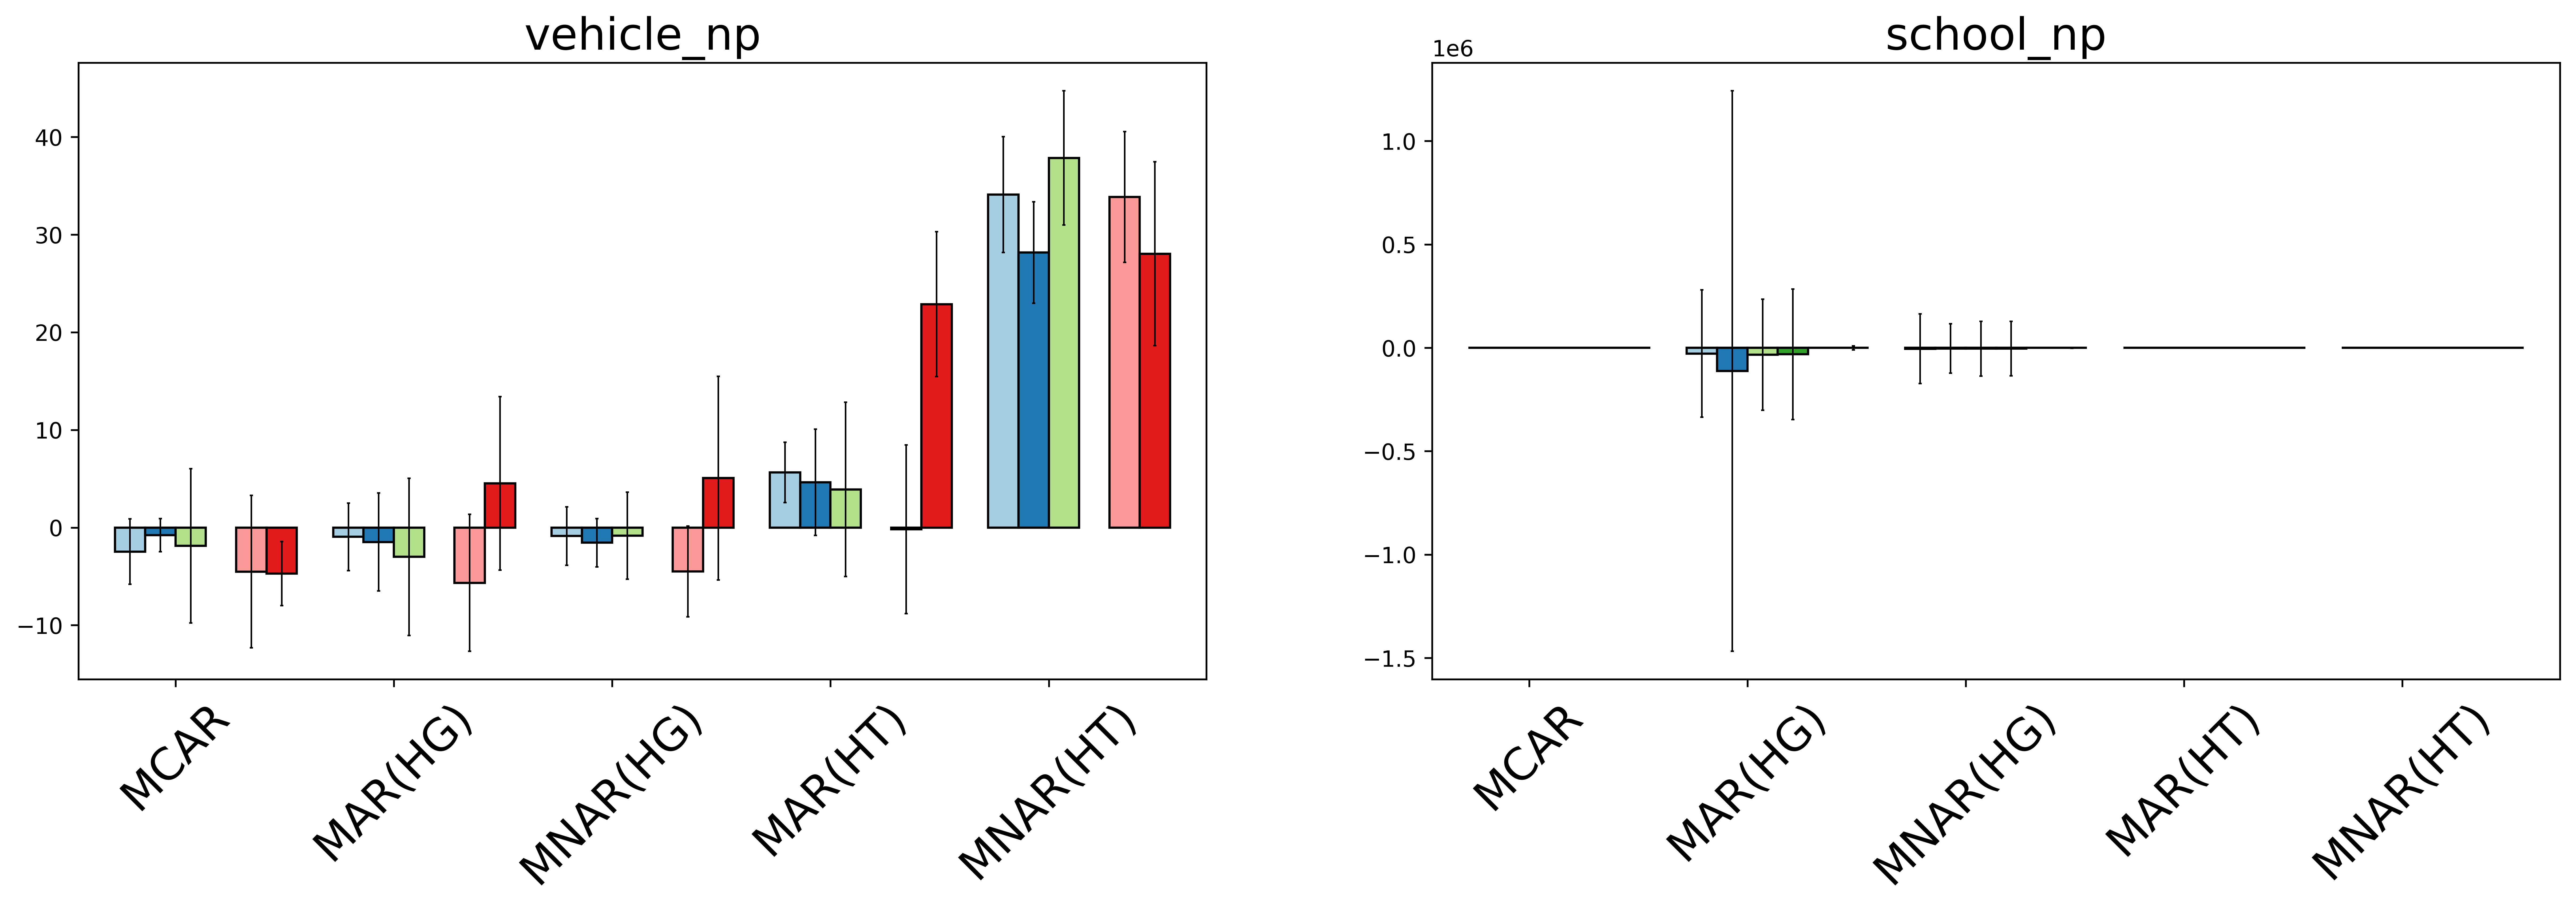

In [70]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# plt.rcParams['text.usetex'] = False
plt.rcParams.update({'figure.dpi': '600'})
df_improv = df_imp_improv
datasets = ['vehicle_np', 'school_np']
methods = ['simple', 'em', 'linear_ice', 'missforest', 'miwae', 'gain']
partition = 'natural-partition'
fed = 'fedavg'
scenarios = ['mcar', 'mar-homog', 'mnar2-homog', 'mar-heter', 'mnar2-heter']
metric = 'rmse_improv'

fig, axes = plt.subplots(1, len(datasets), figsize=(10*len(datasets), 5), squeeze=False)
bin_width = 1.0
interval_width = 1.2
lw = 1
fontsize = 20
edgecolor = 'black'

# for each dataset
row_idx = 0
for col_idx, dataset in enumerate(datasets):
    print(dataset)
    result_avg = df_improv[df_improv['dataset'] == dataset]
    result_avg['imp'] = pd.Categorical(result_avg['imp'], categories=methods, ordered=True)
    
    # for each missing scenario
    for i, scenario in enumerate(scenarios):
        filtered_df = result_avg[
            (result_avg['missing'] == scenario) & (result_avg['fed'] == fed)
        ]
        print(filtered_df.shape)
        # for each imputation methods
        bar_heights = []
        bar_errors = []
        for j in range(len(methods)):
            d = filtered_df[filtered_df['imp'] == methods[j]][metric].values
            bar_heights.append(d.mean())
            bar_errors.append(d.std())
            print(scenario, methods[j], d.mean(), d.std())
            
        bar_positions = [i*interval_width + i*len(methods)*bin_width + j*bin_width for j in range(len(methods))]
        bp = axes[row_idx, col_idx].bar(
            x = bar_positions, height = bar_heights, width = bin_width, linewidth=[lw]*len(methods),
            ecolor=edgecolor, edgecolor = edgecolor, color = colormaps['Paired'].colors[:len(methods)], yerr = bar_errors,
            error_kw = dict(lw=0.7, capsize=0.7, capthick=0.7)
            #hatch = [None, None, None, None,  'x', 'x']
            #color = ['#1e81b0', '#abdbe3', '#7f7f7f', '#d62728'], #hatch = ['\\', 'x', '-',  '/']
        )
        
        # bar labels and positions
        n_groups = len(scenarios)
        n_bars = len(methods)
        x0 = 0 - bin_width/2 - interval_width
        x1 = (n_groups-1)*interval_width + (n_groups-1)*n_bars*bin_width + (n_bars-1)*bin_width + bin_width/2 + interval_width
        axes[row_idx, col_idx].set_xlim([x0, x1])
        axes[row_idx, col_idx].set_xticks([i*interval_width + i*n_bars*bin_width + 1.5*bin_width for i in range(n_groups)])
        axes[row_idx, col_idx].set_xticklabels([scenario_mapping[item] for item in scenarios], fontsize=fontsize, rotation=45) 
        # axes[row_idx, col_idx].set_xlabel('')
        # axes[row_idx, 0].set_ylabel(make_label(dataset_mapping[dataset], dataset_metric_mapping[dataset]), fontsize=fontsize)
        # axes[row_idx, col_idx].tick_params(axis='y', which='major', labelsize=fontsize - 2)
        # axes[row_idx, col_idx].avlines = axes[row_idx, col_idx].axhline(y=0, color='black', linewidth=1)
        # axes[row_idx, col_idx].spines['bottom'].set_color('grey')
        # axes[row_idx, col_idx].spines['top'].set_color('grey')
        # axes[row_idx, col_idx].spines['left'].set_color('grey')
        # axes[row_idx, col_idx].spines['right'].set_color('grey')
        
        # title - dataset
    axes[0, col_idx].set_title(dataset, fontsize=fontsize)

plt.show()

In [64]:
df_imp_improv

,dataset,partition,imp,fed,missing,round_id,client_id,rmse,sliced-ws,rmse_local,rmse_diff,rmse_improv
1100,vehicle_np,natural-partition,simple,fedavg,mcar,0,0,0.209532,0.066743,0.198717,-0.010815,-5.442037
1101,vehicle_np,natural-partition,simple,fedavg,mcar,0,1,0.200324,0.062291,0.193908,-0.006416,-3.308427
1102,vehicle_np,natural-partition,simple,fedavg,mcar,0,2,0.199381,0.053644,0.195987,-0.003394,-1.731622
1103,vehicle_np,natural-partition,simple,fedavg,mcar,0,3,0.191079,0.056772,0.187817,-0.003262,-1.736966
1104,vehicle_np,natural-partition,simple,fedavg,mcar,0,4,0.193131,0.059637,0.190421,-0.002710,-1.423165
...,...,...,...,...,...,...,...,...,...,...,...,...
93519,school_np,natural-partition,gain,fedprox,mnar2-heter,4,134,0.328053,0.128539,0.389346,0.061293,15.742202
93520,school_np,natural-partition,gain,fedprox,mnar2-heter,4,135,0.219298,0.114557,0.310499,0.091201,29.371552
93521,school_np,natural-partition,gain,fedprox,mnar2-heter,4,136,0.316935,0.134140,0.391366,0.074432,19.017934
93522,school_np,natural-partition,gain,fedprox,mnar2-heter,4,137,0.286668,0.117091,0.346062,0.059394,17.162344
